### Generalization


In [1]:
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
"""
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
"""
# gpus = tf.config.list_physical_devices('GPU')
# gpus
#
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12000)])
#   except RuntimeError as e:
#     print(e)

val_performance = {}
performance = {}
val_performance_mae = {}
performance_mae = {}
multi_val_performance = {}
multi_performance = {}
multi_val_performance_mae = {}
multi_performance_mae = {}


2023-03-10 14:09:45.074710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 14:09:46.169226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 14:09:46.169296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-10 14:09:46.169304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def get_cloned_model(model_to_clone,optimizer):
    model_copy= tf.keras.models.clone_model(model_to_clone)
    #model_copy.build((None, 10)) # replace 10 with number of variables in input layer
    model_copy.compile(optimizer=optimizer, loss='mse')
    model_copy.set_weights(model_to_clone.get_weights())
    return model_copy

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import copy
import datetime

class PerformancePlot():
    def plot_test_train(self,name,predicted_train_y,predicted_test_y,wg, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        if wg.moving_average_transformer is not None:
            wg = copy.copy(wg)
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()


        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            performance[name] = rsme_train
            val_performance[name] = rsme_test
            performance_mae[name] = mae_train
            val_performance_mae[name] = mae_test


        plt.subplot(1, 2, 1)
        plt.title("Train "+name)
        plt.plot(x["DaysInYear"], y)
        plt.plot(x["DaysInYear"], predicted_train_y)
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y)
        plt.plot(t_x["DaysInYear"], predicted_test_y)
        plt.grid(True)
    def plot_test_train_multistep2(self,name,predicted_train_y,predicted_test_y, wg, steps, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        tf_x = None
        tf_y = None
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.calc_window()
            f_x,f_y = wg.get_xy_test()
            tf_x,tf_y = wg.get_xy_test()
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            multi_performance[name] = rsme_train
            multi_val_performance[name] = rsme_test
            multi_performance_mae[name] = mae_train
            multi_val_performance_mae[name] = mae_test


        plt.subplot(2, 1, 1)
        plt.title("Train "+name)

        plt.plot(x["DaysInYear"], y.to_numpy()[:,0])
        train_pred_plot = []
        for i in range(predicted_train_y.shape[0])[::steps]:
            train_pred_plot += predicted_train_y[i].tolist()

        plt.plot(x["DaysInYear"], train_pred_plot[:x["DaysInYear"].shape[0]])
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y.to_numpy()[:,0])
        if tf_x is not None:
            plt.plot(tf_x["DaysInYear"], tf_y.to_numpy()[:,0])
        test_pred_plot = []
        for i in range(predicted_test_y.shape[0])[::steps]:
            test_pred_plot += predicted_test_y[i].tolist()
        plt.plot(t_x["DaysInYear"], test_pred_plot[:t_x["DaysInYear"].shape[0]])

        plt.grid(True)

    def plot_test_train_multistep(self,name,predicted_train_y,predicted_test_y, wg, steps, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.moving_average_transformer = None


        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            multi_performance[name] = rsme_train
            multi_val_performance[name] = rsme_test
            multi_performance_mae[name] = mae_train
            multi_val_performance_mae[name] = mae_test


        plt.subplot(2, 1, 1)
        plt.title("Train "+name)

        plt.plot(x["DaysInYear"], y.to_numpy()[:,0])

        for i in range(len(x["DaysInYear"])-steps):
            plt.plot(x["DaysInYear"][i:i+steps], predicted_train_y[i])

        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y.to_numpy()[:,0])

        for i in range(len(t_x["DaysInYear"])-steps):
            plt.plot(t_x["DaysInYear"][i:i+steps], predicted_test_y[i])
        plt.grid(True)

    def plot_test_train_multistep3(self,name,predicted_train_y,predicted_test_y, wg,model_statistic,save_fig=False,xlim=None):
        plt.figure(figsize=(20, 10))

        print(name)
        tf_x = None
        tf_y = None
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.calc_window()
            f_x,f_y = wg.get_xy_test()
            tf_x,tf_y = wg.get_xy_test()
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)
        model_statistic.add(rsme_test)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)

        plt.title(name)


        train_samples = x["DaysInYear"].shape[0]
        test_samples = t_x["DaysInYear"].shape[0]

        train_pred_plot = []
        train_acutal_plot = []
        for i in range(predicted_train_y.shape[0])[::wg.steps]:
            train_pred_plot += predicted_train_y[i].tolist()
            train_acutal_plot += y.to_numpy()[i].tolist()
        plt.plot(train_acutal_plot[:x["DaysInYear"].shape[0]],c='#1f77b4')
        plt.plot(train_pred_plot[:x["DaysInYear"].shape[0]],c='#ff7f0e')
        plt.grid(True)

        #plt.plot(range(train_samples,train_samples+test_samples), t_y.to_numpy()[:,0],c='#1f77b4')
        if tf_x is not None:
            plt.plot(range(train_samples,train_samples+test_samples), tf_y.to_numpy()[:,0])
        test_pred_plot = []
        test_actual_plot = []
        print(predicted_test_y.shape[0])
        for i in range(predicted_test_y.shape[0])[::wg.steps]:
            print(i)
            test_pred_plot += predicted_test_y[i].tolist()
            test_actual_plot += t_y.to_numpy()[i].tolist()
        plt.plot(range(train_samples,train_samples+test_samples), test_pred_plot[:t_x["DaysInYear"].shape[0]],c='r')
        plt.plot(range(train_samples,train_samples+test_samples), test_actual_plot[:t_x["DaysInYear"].shape[0]],c='#1f77b4')

        minor_ticks = np.arange(train_samples, train_samples+test_samples+1, 5)
        #plt.xticks(minor_ticks,minor=False,rotation=45)
        plt.ylabel('standard scaled ordered quantity')
        plt.xlabel('days')
        #plt.grid(which='minor', alpha=0.2)
        #plt.grid(which='major', alpha=0.5)
        plt.legend(['actual curve','predicted train','predicted test'],labelcolor=['#1f77b4','#1f77b4','r'])

        if xlim is not None:
            if xlim < train_samples+test_samples:
                print([train_samples+test_samples-xlim,train_samples+test_samples])
                plt.xlim([train_samples+test_samples-xlim,train_samples+test_samples])

        if save_fig:
            plt.savefig("./img/"+name+"_"+str(datetime.datetime.now())+".png")

        plt.figure(figsize=(10,5))
        plt.title(name)
        print('t_y',t_y.to_numpy().shape)
        print('len test pred plot',len(test_pred_plot))
        plt.plot(test_actual_plot,c='#1f77b4')
        plt.plot(test_pred_plot,c='r')
        minor_ticks = np.arange(0, len(test_pred_plot), 5)
        plt.xticks(minor_ticks,minor=False)
        plt.ylabel('standard scaled ordered quantity')
        plt.xlabel('days')
        plt.grid(which='minor', alpha=0.2)
        plt.grid(which='major', alpha=0.5)
        plt.legend(['actual','predicted'])
        if save_fig:
            plt.savefig("./img/"+name+"_testonly_"+str(datetime.datetime.now())+".png")




In [5]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class QueryByItemNoTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, item_no):
        self.item_no = item_no

    def transform(self, input_df, **transform_params):
        item_no = self.item_no

        if(item_no != None):
            input_df = input_df.query("ItemNo == @item_no").copy()
        else:
            input_df = input_df.copy()
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self
class RenameColumnsTransformer(TransformerMixin,BaseEstimator):
    def transform(self,input_df, **transform_params):
        return input_df.rename(columns={"Week Day":"Weekday"})
    def fit(self, X, y=None, **fit_params):
        return self
class ShiftColumnsTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,shift,use_weather_data):
        self.shift = shift
        self.use_weather_data = use_weather_data
    def transform(self, input_df, **transform_params):
        input_df["OrderedQuantityToday"] = input_df["OrderedQuantity"]
        input_df["OrderedQuantity"] = input_df.shift(-self.shift)["OrderedQuantity"]
        input_df["OrderDateDeltaUnitPrice"] = input_df.shift(-self.shift)["DeltaUnitPrice"]
        input_df["OrderDateUnitPrice"] = input_df.shift(-self.shift)["UnitPrice"]
        input_df["OrderDateNumberOfSundaysAfter"] = input_df.shift(-self.shift)["NumberOfSundaysAfter"]
        input_df["OrderDateNumberOfSundaysBefore"] = input_df.shift(-self.shift)["NumberOfSundaysBefore"]
        input_df["OrderDateDaysInYear"] = input_df.shift(-self.shift)["DaysInYear"]
        input_df["OrderDateWeekday"] = input_df.shift(-self.shift)["Weekday"]
        input_df["OrderDateWeekNumber"] = input_df.shift(-self.shift)["WeekNumber"]
        input_df["OrderDateWeekSin"] = input_df.shift(-self.shift)["WeekSin"]
        input_df["OrderDateWeekCos"] = input_df.shift(-self.shift)["WeekCos"]
        input_df["OrderDateWeekNoSin"] = input_df.shift(-self.shift)["WeekNoSin"]
        input_df["OrderDateWeekNoCos"] = input_df.shift(-self.shift)["WeekNoCos"]
        input_df["OrderDateYearSin"] = input_df.shift(-self.shift)["YearSin"]
        input_df["OrderDateYearCos"] = input_df.shift(-self.shift)["YearCos"]

        if self.use_weather_data:
            input_df["OrderDateMaxTemp"] = input_df.shift(-self.shift)["MaxTemp"]
            input_df["OrderDateTotalPrecip"] = input_df.shift(-self.shift)["TotalPrecip"]

        return input_df.dropna().copy()

    def fit(self, X, y=None, **fit_params):
        return self
class GroupByShipmentDateTransformer(TransformerMixin,BaseEstimator):

    def transform(self, input_df, **transform_params):
        input_df["Timestamp"] = input_df["Shipment Date"]
        totalOrderedQuantity = input_df.groupby(["Timestamp"])["OrderedQuantity"].sum()
        input_df = input_df.groupby(["Timestamp"]).mean(numeric_only=True)
        input_df["OrderedQuantity"] = totalOrderedQuantity
        return input_df.sort_values(by=['Timestamp'])

    def fit(self, X, y=None, **fit_params):
        return self

class DatasetSplitTransformer(TransformerMixin, BaseEstimator):
    def transform(self, input_df, **transform_params):
        item_train_data_x = input_df.drop(["OrderedQuantity"], axis=1)
        item_train_data_y = input_df[["OrderedQuantity"]].copy()
        return item_train_data_x, item_train_data_y

    def fit(self, X, y=None, **fit_params):
        return self
class DropUnusedColumnsTransformer(TransformerMixin, BaseEstimator):
    def __init__(self,use_weather_data):
        self.use_weather_data = use_weather_data

    def transform(self, input_df):
        input_df = input_df.drop(["Quantity", "ShipmentYear","Grund Mengenabweichung","Mengenabweichung","SellToCustomerNo","Sammelpreisliste"], axis=1)
        droppable_weather_columns = ["AvgHumidity","MaxWind","MinTemp","AvgTemp"]
        if input_df.columns.isin(droppable_weather_columns).all():
            input_df = input_df.drop(droppable_weather_columns,axis=1)
        if input_df.columns.isin(["MaxTemp","TotalPrecip"]).all() and not self.use_weather_data:
            input_df = input_df.drop(["MaxTemp","TotalPrecip"],axis=1)

        return input_df.dropna()

    def fit(self, X):
        return self
#save mean and std of quantity of for inverse transform
class StandardScalingTransformer(TransformerMixin,BaseEstimator):

    def __init__(self):
        self.scaler = StandardScaler()
        self.quantity_mean = 0
        self.quantity_std = 1


    def transform(self, input_df):

        columns = input_df.columns
        df_scaled = self.scaler.transform(input_df.to_numpy())
        qantity_feature_no = columns.get_loc("OrderedQuantity")
        self.quantity_mean = self.scaler.mean_[qantity_feature_no]
        self.quantity_std = self.scaler.scale_[qantity_feature_no]

        return pd.DataFrame(df_scaled,columns=columns)

    def fit(self, X):
        self.scaler.fit_transform(X.to_numpy())
        return self

class HistoricTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,length_of_slope,use_weather_data):
        self.length_of_slope = length_of_slope
        self.use_weather_data = use_weather_data
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy()
        for i in range(1,self.length_of_slope+1):
            input_df["OrderedQuantityToday"+str(i)] =  input_df.shift(i)["OrderedQuantityToday"]
            #input_df["NextOrderIn"+str(i)] = input_df.shift(i-1)["DaysInYear"] - input_df.shift(i)["DaysInYear"]
            input_df["UnitPrice"+str(i)] = input_df.shift(i)["UnitPrice"]
            input_df["DeltaUnitPrice"+str(i)] = input_df.shift(i)["DeltaUnitPrice"]
            input_df["NumberOfSundaysAfter"+str(i)] = input_df.shift(i)["NumberOfSundaysAfter"]
            input_df["NumberOfSundaysBefore"+str(i)] = input_df.shift(i)["NumberOfSundaysBefore"]
            input_df["Weekday"+str(i)] = input_df.shift(i)["Weekday"]
            input_df["WeekNumber"+str(i)] = input_df.shift(i)["WeekNumber"]
            input_df["DaysInYear"+str(i)] = input_df.shift(i)["DaysInYear"]
            input_df["WeekCos"+str(i)] = input_df.shift(i)["WeekCos"]
            input_df["WeekSin"+str(i)] = input_df.shift(i)["WeekSin"]
            input_df["WeekNoSin"+str(i)] = input_df.shift(i)["WeekNoSin"]
            input_df["WeekNoCos"+str(i)] = input_df.shift(i)["WeekNoCos"]
            input_df["YearSin"+str(i)] = input_df.shift(i)["YearSin"]
            input_df["YearCos"+str(i)] = input_df.shift(i)["YearCos"]

            if self.use_weather_data:
                # input_df["MinTemp"+str(i)] = input_df.shift(i)["MinTemp"]
                input_df["MaxTemp"+str(i)] = input_df.shift(i)["MaxTemp"]
                # input_df["AvgTemp"+str(i)] = input_df.shift(i)["AvgTemp"]
                # input_df["MaxWind"+str(i)] = input_df.shift(i)["MaxWind"]
                input_df["TotalPrecip"+str(i)] = input_df.shift(i)["TotalPrecip"]
                # input_df["AvgHumidity"+str(i)] = input_df.shift(i)["AvgHumidity"]
            input_df = input_df.copy()
        return input_df.dropna().copy()

    def fit(self, X, y=None, **fit_params):
        return self

class FillMissingValuesTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,use_weather_data):
        self.use_weather_data = use_weather_data


    def transform(self, input_df, **transform_params):
        input_df = input_df.asfreq('D')
        input_df['Shipment Date'] = input_df.index
        input_df['Weekday'] = input_df['Shipment Date'].dt.dayofweek
        input_df['DaysInYear'] = input_df['Shipment Date'].dt.day_of_year
        input_df['UnitPrice'] = input_df['UnitPrice'].fillna(method='bfill')
        input_df['OrderedQuantity'] = input_df['OrderedQuantity'].fillna(method='bfill')
        if self.use_weather_data:
            input_df['MaxTemp'] = input_df['MaxTemp'].fillna(method='bfill')
            input_df['TotalPrecip'] = input_df['TotalPrecip'].fillna(method='bfill')
        input_df['WeekNumber'] = input_df['Shipment Date'].dt.isocalendar().week

        week = 7*24*60*60
        year = 60*40*24*365.25
        weeks_per_year = 53
        timestamp_s = input_df['Shipment Date'].map(pd.Timestamp.timestamp)
        input_df['WeekSin'] = np.sin(timestamp_s*(2*np.pi /week))
        input_df['WeekCos'] = np.cos(timestamp_s*(2*np.pi /week))
        input_df['YearSin'] = np.sin(timestamp_s*(2*np.pi /year))
        input_df['YearCos'] = np.cos(timestamp_s*(2*np.pi /year))
        input_df['WeekNoSin'] = np.sin(input_df['WeekNumber']*(2*np.pi /weeks_per_year))
        input_df['WeekNoCos'] = np.cos(input_df['WeekNumber']*(2*np.pi /weeks_per_year))


        #input_df['isHoliday'] = input_df['Shipment Date'] in swiss_holidays
        #input_df['isSunday'] = input_df['Shipment Date'].dt.dayofweek == 6
        input_df['NumberOfSundaysBefore'] = input_df['NumberOfSundaysBefore'].fillna(0)
        input_df['NumberOfSundaysAfter'] = input_df['NumberOfSundaysAfter'].fillna(0)
        input_df = input_df.drop(['Shipment Date'],axis=1)
        return input_df
    def fit(self,x):
        return self
class DeltaUnitPriceTransformer(TransformerMixin,BaseEstimator):

    def transform(self, input_df, **transform_params):
        input_df['DeltaUnitPrice'] = input_df['UnitPrice'].shift(1) -input_df['UnitPrice']
        input_df['DeltaUnitPrice'] = input_df['DeltaUnitPrice'].fillna(0)

        return input_df
    def fit(self,x):
        return self

class MovingAverageTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,length_of_moving_average,affected_columns=["OrderedQuantity"]):
        self.length_of_moving_average = length_of_moving_average
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        input_df[self.affected_columns] = input_df[self.affected_columns].rolling(self.length_of_moving_average,min_periods=1).mean()
        return input_df
    def fit(self,x):
        return self

class ExponentialMovingAverageTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,alpha,adjust=False,affected_columns = ["OrderedQuantity"]):
        self.alpha = alpha
        self.adjust = adjust
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        input_df[self.affected_columns] = input_df[self.affected_columns].ewm(alpha=self.alpha,adjust=self.adjust).mean()
        return input_df
    def fit(self,x):
        return self
from scipy.signal import medfilt
class MedianFilterTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,kernel_size=3,affected_columns=["OrderedQuantity"]):
        self.kernel_size = kernel_size
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        #do not use mefilter -> medfilter is looking forward

        med_column = input_df[self.affected_columns].copy()
        for i in range(1,input_df.shape[0]):
            if i < self.kernel_size:
                window = i
            else:
                window = self.kernel_size
            med = np.median(input_df[self.affected_columns].iloc[i-window:i])
            med_column.iloc[i] = med
        input_df[self.affected_columns] = med_column

        #input_df["OrderedQuantity"] = medfilt(input_df["OrderedQuantity"],kernel_size=self.kernel_size)
        return input_df
    def fit(self,x):
        return self
#baseline model
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

class WindowGenerator():

    def __init__(self, train_data, test_data, item_no=None,lookback=1, offset=1,steps=1,predict_moving_average=False,use_weather_data=False,use_standard_scaling=False,moving_average_transformer=None,
                 only_used_features=None,embedding=None):
        self.train_data = train_data
        self.test_data = test_data
        self.item_no = None
        self.lookback = lookback
        self.offset = offset
        self.steps = steps
        self.predict_moving_average = predict_moving_average
        self.use_weather_data = use_weather_data
        self.use_standard_scaling = use_standard_scaling
        self.item_no = item_no
        self.moving_average_transformer = moving_average_transformer
        self.only_used_features = only_used_features
        self.embedding = embedding

    def set_train_data(self,train_data):
        self.train_data = train_data

    def set_test_data(self,test_data):
        self.test_data = test_data

    def set_item_query(self,item_no):
        self.item_no = item_no

    def get_xy_train(self):
        return self.train_x,self.train_y
    def get_xy_test(self):
        return self.test_x,self.test_y

    def calc_window(self):
        self._calc_window(self.train_data, False)
        self._calc_window(self.test_data, True)

    def get_feature_tensor_test(self):
        return self._get_feature_tensor(self.test_x)
    def get_feature_tensor_train(self):
        return self._get_feature_tensor(self.train_x)

    def get_feature_tensor2_test(self):
        return self._get_feature_tensor2(self.test_x)
    def get_feature_tensor2_train(self):
        return self._get_feature_tensor2(self.train_x)

    def _calc_window(self, data, is_test_set):
        panda_frame_pipeline = self._get_pipeline(is_test_set)
        if not is_test_set:
            x,y = panda_frame_pipeline.fit_transform(data)
        else:
            x,y = panda_frame_pipeline.transform(data)

        x = HistoricTransformer(self.lookback,self.use_weather_data).fit_transform(x)
        y = y.shift(-self.lookback).dropna()

        if self.predict_moving_average:
            for i in range(1,self.steps):
                _y = y.copy()
                _x = x.copy()
                _y = _y.shift(-i)
                _x = _x.shift(-i)
                y["OrderedQuantity"] += _y["OrderedQuantity"]
                x["OrderDateWeekday"] += _x["OrderDateWeekday"]
                x["OrderDateUnitPrice"] += _x["OrderDateUnitPrice"]
                x["OrderDateDeltaUnitPrice"] += _x["OrderDateDeltaUnitPrice"]
                x["OrderDateWeekNumber"] += _x["OrderDateWeekNumber"]
                x["OrderDateNumberOfSundaysAfter"] += _x["OrderDateNumberOfSundaysAfter"]
                x["OrderDateNumberOfSundaysBefore"] += _x["OrderDateNumberOfSundaysBefore"]
            y["OrderedQuantity"] /= self.steps

        else:

            for i in range(1,self.steps):
                _y = y.copy()
                _x = x.copy()
                _y = _y.shift(-i)
                _x = _x.shift(-i)
                y["OrderedQuantity"+str(i)] = _y["OrderedQuantity"]
                x["OrderDateUnitPrice"+str(i)] = _x["OrderDateUnitPrice"]
                x["OrderDateNumberOfSundaysAfter"+str(i)] = _x["OrderDateNumberOfSundaysAfter"]
                x["OrderDateNumberOfSundaysBefore"+str(i)] = _x["OrderDateNumberOfSundaysBefore"]
                x["OrderDateWeekday"+str(i)] = _x["OrderDateWeekday"]
                x["OrderDateDeltaUnitPrice"+str(i)] = _x["OrderDateDeltaUnitPrice"]
                x["OrderDateWeekNumber"+str(i)] = _x["OrderDateWeekNumber"]
                x["OrderDateDaysInYear"+str(i)] = _x["OrderDateDaysInYear"]
                x["OrderDateWeekCos"+str(i)] = _x["OrderDateWeekCos"]
                x["OrderDateWeekSin"+str(i)] = _x["OrderDateWeekSin"]
                x["OrderDateWeekNoCos"+str(i)] = _x["OrderDateWeekNoCos"]
                x["OrderDateWeekNoSin"+str(i)] = _x["OrderDateWeekNoSin"]
                x["OrderDateYearCos"+str(i)] = _x["OrderDateYearCos"]
                x["OrderDateYearSin"+str(i)] = _x["OrderDateYearSin"]
                if self.use_weather_data:
                    x["OrderDateMaxTemp"+str(i)] = _x["OrderDateMaxTemp"]
                    x["OrderDateTotalPrecip"+str(i)] = _x["OrderDateTotalPrecip"]
                # x["NextOrderIn"+str(i)] = _x["NextOrderIn"] +x["NextOrderIn"]
                # replace NextOrderIn with OrderDayOfYear
                x = x.copy()
        x = x.dropna()
        y = y.dropna()
        if is_test_set:
            self.test_x = x
            self.test_y = y
        else:
            self.train_x = x
            self.train_y = y
        return x,y

    def get_future_info(df, iloc, predicted_quantity):
        next_entry = df.iloc[iloc+1]
        next_entry["OrderedQuantityToday"] = predicted_quantity
        return next_entry
    def _get_pipeline(self,is_test_set):


        transformations = [
            ('rename columns', RenameColumnsTransformer()),
            ('query_by_item_no',QueryByItemNoTransformer(self.item_no)),
            ('drop_unused_columns',DropUnusedColumnsTransformer(self.use_weather_data)), # every non-numeric column will be dropped
            ('group_by_shipmentdate',GroupByShipmentDateTransformer()),
            ('Fill Missing Values', FillMissingValuesTransformer(self.use_weather_data)),
            ('Add DeltaUnitPrice', DeltaUnitPriceTransformer()),
            ('shift_columns',ShiftColumnsTransformer(self.offset,self.use_weather_data)),
            ('dataset_split_transformer',DatasetSplitTransformer())]

        if self.use_standard_scaling:
            #only calculating scaler for train set
            if not is_test_set:
                self.standard_scaling = StandardScalingTransformer()
            transformations.insert(5,('standard_scaling',self.standard_scaling))

        if self.moving_average_transformer is not None:
            transformations.insert(6,('moving_average_transformer',self.moving_average_transformer))

        return Pipeline(transformations)

    def inverse_transform(self, y):
        if self.use_standard_scaling:
            return (y * self.standard_scaling.quantity_std)+self.standard_scaling.quantity_mean
        return y

    def _get_feature_tensor(self, x):
        columns = ["OrderedQuantityToday","DeltaUnitPrice","UnitPrice","NumberOfSundaysAfter","NumberOfSundaysBefore","Weekday","DaysInYear","WeekNumber","WeekCos","WeekSin","YearSin","YearCos","WeekNoSin","WeekNoCos"]
        if self.use_weather_data:
            columns += ["MaxTemp","TotalPrecip"]

        if self.only_used_features is not None:
            columns = list(set(columns).intersection(set(self.only_used_features)))


        conv_today = x[columns].to_numpy()[:,np.newaxis,...]


        for i in range(1,self.lookback+1):
            prev_columns = [column + str(i) for column in columns]
            conv_prev_day = x[prev_columns].to_numpy()[:,np.newaxis,...]
            conv_today = np.concatenate((conv_prev_day,conv_today), axis=1)

        if self.embedding is not None:
            v = self.embedding.get_embedding_vector(self.item_no)
            v = v.reshape(1,v.shape[1])
            v = v.repeat(conv_today.shape[1],axis=0)
            v = v.reshape(1,v.shape[0],v.shape[1])
            v = v.repeat(conv_today.shape[0],axis=0)


            conv_today = np.concatenate((conv_today,v),axis=2)


        return conv_today

    def _get_feature_tensor2(self, x):
        columns = ["OrderDateUnitPrice","OrderDateNumberOfSundaysBefore","OrderDateNumberOfSundaysAfter","OrderDateWeekday","OrderDateDeltaUnitPrice","DaysInYear","OrderDateWeekNumber","OrderDateWeekCos","OrderDateWeekSin","OrderDateSinYear","OrderDateCosYear","OrderDateWeekNoSin","OrderDateWeekNoCos"]
        if self.use_weather_data:
            columns += ["OrderDateMaxTemp","OrderDateTotalPrecip"]

        if self.only_used_features is not None:
            columns = list(set(columns).intersection(set(self.only_used_features)))
        column_list = columns.copy()
        for i in range(1,self.steps):
            column_list += [column+str(i) for column in columns]

        return x[column_list].copy()


In [6]:
import pandas as pd
import pickle

with open('prodega_daten_full/frames.pickle', 'rb') as handle:
    frames = pickle.load(handle)

with open('denner_daten_full_weather/frames.pickle', 'rb') as handle:
    frames2 = pickle.load(handle)



In [8]:
class Embedding:

    def __init__(self,frames,output_dim):
        self.items = []
        self.output_dim = output_dim
        for frame in frames:
            self.items.append(frame['ItemNo'].min())

        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Embedding(len(self.items)+1, self.output_dim, input_length=1))
        self.model.compile('rmsprop', 'mse')

    def get_embedding_vector(self,item_no):
        return self.model.predict(np.array(self.items.index(item_no)).reshape(1,1),verbose=False)[0]


class ClusterEmbedding:

    def __init__(self,frames,cluster_members,output_dim):
        self.items = []
        self.output_dim = output_dim
        for frame in frames:
            self.items.append(frame['ItemNo'].min())

        self.model = tf.keras.Sequential()
        self.cluster_members = cluster_members
        self.model.add(tf.keras.layers.Embedding(len(self.cluster_members), self.output_dim, input_length=1))
        self.model.compile('rmsprop', 'mse')

    def get_embedding_vector(self,item_no):
        return self.model.predict(np.array(self.cluster_members[self.items.index(item_no)]).reshape(1,1),verbose=False)[0]


In [9]:
import datetime
class Frame:
    def __init__(self, item_no = None, train_x = None, train_y = None, test_x = None, test_y = None, wg = None,train_data = None,test_data = None):
        self.item_no = item_no
        self.train_x = train_x
        self.train_y = train_y
        self.test_x  = test_x
        self.test_y = test_y
        self.wg = wg
        self.train_data = train_data
        self.test_data = test_data

class Fold:
    def __init__(self):
        self.all_data = []
        self.frames = []
class KFoldSplitting:
    def __init__(self,number_of_folds,test_period_in_days,window_generator,skip_first_fold=False,percent_of_training_data_used=1.0):
        self.test_period_in_days = test_period_in_days
        self.number_of_folds = number_of_folds
        self.window_generator = window_generator
        self.skip_first_fold = skip_first_fold
        self.percent_of_training_data_used = percent_of_training_data_used


    def get_datasets(self,frames):
        splits = self._split(frames)
        datasets = []

        i = 0
        for split in splits:
            i+=1
            train_x_list = []
            test_x_list = []
            train_y_list = []
            test_y_list = []
            fold = Fold()
            for train_data, test_data in split:
                if train_data.groupby(["Shipment Date"])['OrderedQuantity'].mean(numeric_only=True).dropna().shape[0] < self.window_generator.lookback + self.window_generator.steps +1:
                    fold.frames.append(Frame())
                    continue
                if test_data.groupby(["Shipment Date"])['OrderedQuantity'].mean(numeric_only=True).dropna().shape[0] < self.window_generator.lookback + self.window_generator.steps +1:
                    fold.frames.append(Frame())
                    continue

                self.window_generator.set_train_data(train_data)
                self.window_generator.set_test_data(test_data)
                self.window_generator.item_no = train_data['ItemNo'].iloc[0]
                self.window_generator.calc_window()

                train_x = self.window_generator.get_feature_tensor_train()
                test_x = self.window_generator.get_feature_tensor_test()
                train_x_list.append(train_x)
                test_x_list.append(test_x)
                _,train_y = self.window_generator.get_xy_train()
                _,test_y = self.window_generator.get_xy_test()
                train_y_list.append(train_y)
                test_y_list.append(test_y)
                print(i,self.window_generator.get_feature_tensor_train().shape[0])
                frame = Frame(item_no = train_data['ItemNo'].iloc[0],train_x = train_x,train_y = train_y,test_x = test_x,wg = self.window_generator,train_data = train_data, test_data = test_data,test_y=test_y)
                fold.frames.append(frame)
            if len(train_x_list) > 0:
                train_x_all = np.concatenate(train_x_list,axis=0)
                train_y_all = np.concatenate(train_y_list,axis=0)
                test_x_all = np.concatenate(test_x_list,axis=0)
                test_y_all = np.concatenate(test_y_list,axis=0)
                fold.all_data = (train_x_all,train_y_all,test_x_all,test_y_all)
                datasets.append(fold)

        return datasets

    def _split(self, frames):

        splits = []
        for idx in range(1,self.number_of_folds+1):
            if idx == 1 and self.skip_first_fold:
                continue
            splitted_frames = []
            for frame in frames:

                starting_date = frame['Shipment Date'].min().to_pydatetime()
                ending_date = frame['Shipment Date'].max().to_pydatetime()
                number_of_days = int((ending_date - starting_date).total_seconds() / 60 / 60 / 24)
                number_of_days = int(number_of_days*self.percent_of_training_data_used)
                starting_date = ending_date - datetime.timedelta(days=number_of_days)
                range_of_fold = number_of_days / self.number_of_folds

                end_date_train_set = starting_date + datetime.timedelta(days=range_of_fold*idx-self.test_period_in_days)
                start_test_set = end_date_train_set + datetime.timedelta(days=1)
                end_test_set = starting_date + datetime.timedelta(days=range_of_fold*idx)
                train_frame = frame[frame["Shipment Date"] <= end_date_train_set]
                train_frame = train_frame[train_frame["Shipment Date"] >= starting_date]
                test_frame = frame[frame["Shipment Date"] >= start_test_set]
                test_frame =  test_frame[test_frame["Shipment Date"] <= end_test_set]
                splitted_frames.append((train_frame,test_frame))
            splits.append(splitted_frames)
        return splits


    def _get_starting_date(self,frames):

        min_date = pd.Timestamp('2100-01-01')
        for frame in frames:
            date = frame['Shipment Date'].min()
            if min_date > date:
                min_date = date
        return min_date

    def _get_ending_date(self,frames):

        max_date = pd.Timestamp('2000-01-01')
        for frame in frames:
            date = frame['Shipment Date'].max()
            if max_date < date:
                max_date = date
        return max_date

In [10]:
class ModelStatistic:
    def __init__(self,name):
        self.values = []
        self.name = name
    def add(self,value):
        self.values.append(value)
    def get_avg(self):
        return np.average(np.array(self.values))
    def get_min(self):
        return np.min(np.array(self.values))
    def get_max(self):
        return np.max(np.array(self.values))
    def get_std(self):
        return np.std(np.array(self.values))
    def __str__(self):
        return " name: {name}\n avg: {avg}\n min: {min}\n max: {max}\n std: {std} ".format(name=self.name,avg=self.get_avg(),min=self.get_min(),max=self.get_max(),std=self.get_std())

class FoldStatistic:
    def __init__(self, name):
        self.model_statistic = []
        self.name = name

    def add(self,value):
        self.model_statistic.append(value)
    def get_avg(self):
        return np.average([fold.get_avg() for fold in self.model_statistic])
    def get_min(self):
        return np.min(np.array([fold.get_min() for fold in self.model_statistic]))
    def get_max(self):
        return np.max(np.array([fold.get_max() for fold in self.model_statistic]))
    def get_std(self):
        return np.std(np.array([fold.get_avg() for fold in self.model_statistic]))
    def __str__(self):
        return " name: {name}\n avg: {avg}\n min: {min}\n max: {max}\n std: {std} ".format(name=self.name,avg=self.get_avg(),min=self.get_min(),max=self.get_max(),std=self.get_std())


In [10]:
import os
lookback = 14
steps = 5
onefold_pickle_path = 'prodega_daten_full/folds1.pickle'
if os.path.exists(onefold_pickle_path):
    with open(onefold_pickle_path, 'rb') as handle:
        folds_weather_data = pickle.load(handle)
else:
    embedding = Embedding(frames,6)
    wg = WindowGenerator(None,None,lookback=lookback,offset=1,steps=steps,use_standard_scaling=True,moving_average_transformer=None, use_weather_data=None,embedding=embedding)
    kfold_splitting = KFoldSplitting(1,60,wg)
    folds_weather_data = kfold_splitting.get_datasets(frames)
    with open(onefold_pickle_path, 'wb') as handle:
        pickle.dump(folds_weather_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 16:55:28        70448
config.json                                    2023-03-01 16:55:28          919
metadata.json                                  2023-03-01 16:55:28           64


2023-03-10 13:38:37.963936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 13:38:39.117957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21793 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......embedding
.........vars
............0
...optimizer
......vars
.........0
...vars


In [11]:
import os
lookback = 14
steps = 5
onefold_pickle_path = 'prodega_daten_full/folds1_denner_prodega.pickle'
if os.path.exists(onefold_pickle_path):
    with open(onefold_pickle_path, 'rb') as handle:
        folds_all = pickle.load(handle)
else:
    embedding = Embedding(frames+frames2,6)
    wg = WindowGenerator(None,None,lookback=lookback,offset=1,steps=steps,use_standard_scaling=True,moving_average_transformer=None, use_weather_data=None,embedding=embedding)
    kfold_splitting = KFoldSplitting(1,60,wg)
    folds_all = kfold_splitting.get_datasets(frames+frames2)
    with open(onefold_pickle_path, 'wb') as handle:
        pickle.dump(folds_all, handle, protocol=pickle.HIGHEST_PROTOCOL)


2023-03-10 14:10:07.418259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 14:10:07.901062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21796 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


1 1355
1 1414
1 1410
1 1414
1 416
1 486
1 1411
1 1414
1 58
1 376
1 862
1 1414
1 1414
1 390
1 116
1 543
1 1414
1 1413
1 164
1 1179
1 452
1 1174
1 1178
1 1328
1 347
1 475
1 1414
1 350
1 746
1 355
1 1128
1 1414
1 1100
1 844
1 1367
1 1365
1 1413
1 646
1 309
1 13
1 1016
1 277
1 1414
1 410
1 1176
1 1414
1 392
1 1294
1 730
1 1149
1 1413
1 1294
1 1414
1 1267
1 1338
1 1093
1 1414
1 1414
1 1414
1 68
1 1410
1 1414
1 1414
1 1414
1 1158
1 191
1 1408
1 1414
1 1414
1 1414
1 1339
1 1414
1 1413
1 1414
1 1413
1 1413
1 642
1 642
1 642
1 480
1 642
1 642
1 1413
1 1414
1 1144
1 1146
1 391
1 1414
1 1401
1 211
1 1414
1 1396
1 1268
1 1270
1 427
1 21
1 1414
1 1414
1 1413
1 424
1 373
1 702
1 540
1 1279
1 693
1 641
1 391
1 1413
1 10
1 1414
1 10
1 1414
1 405
1 1408
1 1414
1 1413
1 376
1 1270
1 1287
1 598
1 1414
1 721
1 610
1 725
1 725
1 335
1 1000
1 55
1 1414
1 995
1 380
1 1414
1 1392
1 490
1 753
1 1414
1 1413
1 769
1 1414
1 768
1 334
1 1000
1 376
1 770
1 1331
1 1168
1 777
1 1414
1 565
1 564
1 830
1 435
1 564
1 14

In [19]:
folds_all

In [13]:
import numpy as np
import keras
import math

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,x,y, batch_size=32,noise_ratio =0.1, shuffle=True):
        'Initialization'
        print('data generator with noise ratio',noise_ratio)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.noise_ratio = noise_ratio
        self.number_of_samples = x.shape[0]
        self.indexes = np.arange(x.shape[0])

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch

        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Generate data
        x = self.x[indexes].copy()
        x[:,:,0] += (np.random.normal(size=(x.shape[0],x.shape[1]))*self.noise_ratio)

        y = self.y[indexes]
        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.indexes)

In [22]:
from keras.callbacks import EarlyStopping

def evaluate_model(name,model,folds,evaluation_items = None,eval_all_items=False,batch_size =32,use_data_generator=False,epochs=5,only_evaluation=False,finetune=False,item_labels=None,skip_training=False,start_at = 0):
    idx = 0

    fold_statistic = FoldStatistic('fold '+name)
    model_statistics = ModelStatistic(name)
    for fold in folds:
        train_x,train_y,test_x,test_y = fold.all_data
        idx+=1
        print('fold',idx)

        if not skip_training:
            if not use_data_generator:
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
                history = model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=epochs,callbacks=[es],batch_size=batch_size)
            else:
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
                dg = DataGenerator(train_x,train_y,batch_size=batch_size,noise_ratio=0.2)
                history = model.fit(dg,validation_data=(test_x,test_y),epochs=epochs,callbacks=[es],batch_size=batch_size)

        loss = model.evaluate(test_x,test_y)
        model_statistics.add(loss)
        if not only_evaluation:
            pd.DataFrame(history.history).plot()
        model_statistic = ModelStatistic('')

        for _i, frame in zip(range(len(fold.frames)),fold.frames):
            if _i < start_at:
                continue
            if not eval_all_items:
                if evaluation_items is not None and not  frame.item_no in evaluation_items:
                    continue
            if frame.wg is None:
                model_statistic.add(np.nan)
                continue

            perf_plot = PerformancePlot()
            frame.wg.lookback = lookback
            frame.wg.steps = steps
            frame.wg.set_train_data(frame.train_data)
            frame.wg.set_test_data(frame.test_data)
            frame.wg.item_no = frame.item_no
            frame.wg.calc_window()
            _train_x = frame.wg.get_feature_tensor_train()
            _test_x = frame.wg.get_feature_tensor_test()
            _,_test_y =frame.wg.get_xy_test()
            _,_train_y = frame.wg.get_xy_train()


            if not only_evaluation:
                plot_title = name+' itemNo: '+frame.item_no
                if item_labels is not None:
                    plot_title = 'model: '+name+', item: '+item_labels[evaluation_items.index(frame.item_no)]

                perf_plot.plot_test_train_multistep3(plot_title,model.predict(_train_x,verbose=False).reshape(_train_y.shape),model.predict(_test_x,verbose=False).reshape(_test_y.shape),frame.wg,model_statistic,save_fig=True,xlim=120)
            else:
                if finetune:
                    ftm = get_cloned_model(model,keras.optimizers.Adam(learning_rate=1e-8))
                    ftm.fit(_train_x,_train_y,validation_data=(_test_x,_test_y),epochs=epochs,callbacks=[es],batch_size=batch_size,verbose=False)
                    rmse = np.sqrt(mean_squared_error(_test_y.to_numpy(),ftm.predict(_test_x,verbose=False).reshape(_test_y.shape)))
                    model_statistic.add(rmse)
                else:
                    rmse = np.sqrt(mean_squared_error(_test_y.to_numpy(),model.predict(_test_x,verbose=False).reshape(_test_y.shape)))
                    model_statistic.add(rmse)

        fold_statistic.add(model_statistic)
    if not only_evaluation:
        print('folds statstic')
        print(fold_statistic)
        print('model statistic')
        print(model_statistics)
    return fold_statistic,model_statistics


In [15]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
def evaluate_traditional_algorithm(model,folds):
    for fold in folds:
        model_statistic = ModelStatistic(str(model))
        for frame in fold.frames:
            if frame.wg is None:
                model_statistic.add(np.nan)
                continue
            #if evaluation_items is not None and not  frame.item_no in evaluation_items:
            #    continue
            perf_plot = PerformancePlot()
            frame.wg.set_train_data(frame.train_data)
            frame.wg.set_test_data(frame.test_data)
            frame.wg.item_no = frame.item_no
            frame.wg.calc_window()
            train_x,train_y = frame.wg.get_xy_train()
            test_x,test_y = frame.wg.get_xy_test()
            model.fit(train_x.to_numpy(),train_y.to_numpy())
            model_statistic.add(np.sqrt(mean_squared_error(model.predict(test_x.to_numpy()),test_y)))
            #perf_plot.plot_test_train_multistep3(' - fold ',model.predict(train_x),model.predict(test_x,verbose=False),frame.wg,model_statistic,save_fig=True,xlim=
            print(frame.wg.item_no)
        print(model_statistic)
        return model_statistic

In [16]:
svr = SVR(kernel="linear")
regr = MultiOutputRegressor(svr)
model_statistic_svr = evaluate_traditional_algorithm(regr,folds_weather_data)

NameError: name 'folds_weather_data' is not defined

In [16]:
len(folds_weather_data[0].frames)

825

In [17]:
generalization_path = 'denner_daten_full_weather/svr-result-prodega.pickle'
with open(generalization_path, 'wb') as handle:
        pickle.dump(model_statistic_svr, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
result_path = 'denner_daten_full_weather/svr-result-prodega.pickle'
with open(result_path, 'rb') as handle:
    model_statistic_svr = pickle.load(handle)

In [17]:
from tensorflow.keras.layers import Conv1D,InputLayer,Dropout,Dense,Flatten,Conv1DTranspose,Cropping1D,Reshape

def build_ae_conv1d2(lookback,features,steps,optimizer):
    conv1d = tf.keras.Sequential()
    conv1d.add(InputLayer(input_shape=(lookback,features)))

    conv1d.add(Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    conv1d.add(Flatten())
    preflat_shape = conv1d.layers[-1].input.get_shape().as_list()[1:]

    conv1d.add(Dense(2,name='lateral_layer'))
    conv1d.add(Dense(np.prod(preflat_shape),activation='elu'))
    conv1d.add(Reshape(preflat_shape))
    conv1d.add(Conv1DTranspose(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1DTranspose(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    cropping = conv1d.layers[-1].output_shape[1] - steps
    conv1d.add(Cropping1D(cropping=((0,cropping))))


    conv1d.add(Flatten())
    conv1d.add(Dropout(rate=0.2))
    conv1d.add(Dense(steps))
    conv1d.compile(optimizer=optimizer, loss='mean_squared_error')
    conv1d.summary()
    return conv1d


def build_gru_model(lookback, features, steps,optimizer):
    gru_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        InputLayer(input_shape=(lookback,features)),
        #tf.keras.layers.LSTM(features, kernel_regularizer=tf.keras.regularizers.l2(0.01),return_sequences=True),
        tf.keras.layers.GRU(features, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.RepeatVector(steps),
        tf.keras.layers.GRU(features, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.TimeDistributed(Dense(100, activation='elu')),
        tf.keras.layers.TimeDistributed(Dense(1))
        # Shape => [batch, time, features]
        #tf.keras.layers.Dense(units=1)
    ])
    gru_model.compile(loss='mse',optimizer=optimizer)
    gru_model.summary()
    return gru_model

def build_bidirectional_lstm_model(lookback, features, steps,optimizer):
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        InputLayer(input_shape=(lookback,features)),
        #tf.keras.layers.LSTM(features, kernel_regularizer=tf.keras.regularizers.l2(0.01),return_sequences=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(features, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.RepeatVector(steps),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(features, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.TimeDistributed(Dense(32, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.TimeDistributed(Dense(16, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.TimeDistributed(Dense(8, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.TimeDistributed(Dense(1))])
    lstm_model.compile(loss='mse',optimizer=optimizer)
    lstm_model.summary()
    return lstm_model

def build_lstm_model(lookback, features, steps,optimizer):
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        InputLayer(input_shape=(lookback,features)),
        #tf.keras.layers.LSTM(features, kernel_regularizer=tf.keras.regularizers.l2(0.01),return_sequences=True),
        tf.keras.layers.LSTM(features, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.RepeatVector(steps),
        tf.keras.layers.LSTM(features, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.TimeDistributed(Dense(64, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.TimeDistributed(Dense(1))
        # Shape => [batch, time, features]
        #tf.keras.layers.Dense(units=1)
    ])
    lstm_model.compile(loss='mse',optimizer=optimizer)
    lstm_model.summary()
    return lstm_model

def build_ae_conv1d(lookback,features,steps,optimizer = None):
    conv1d = tf.keras.Sequential()
    conv1d.add(InputLayer(input_shape=(lookback,features)))
    #conv1d.add(Conv1D(2, 3,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    #conv1d.add(Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    #conv1d.add(Conv1D(filters, 3, stride=2,activation="elu", padding="same"))
    conv1d.add(Flatten())
    #conv1d.add(Dropout(rate=0.2))
    #conv1d.add(Dense(10,activation='elu'))
    conv1d.add(Dense(steps))
    if optimizer is None:
        conv1d.compile(optimizer='adam', loss='mean_squared_error')
    else:
        print('using custom optimizer',optimizer)
        conv1d.compile(optimizer=optimizer,loss='mean_squared_error')
    conv1d.summary()
    return conv1d

In [18]:
#load pretrained model
import pickle
result_path = 'denner_daten_full_weather/gru-noise.pickle'
with open(result_path, 'rb') as handle:
    gru_noise = pickle.load(handle)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 14:28:32        55472
config.json                                    2023-03-01 14:28:32         3733
metadata.json                                  2023-03-01 14:28:32           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
......gru_1
.........cell
............vars
...............0
...............1
...............2
.........vars
......repeat_vector
.........vars
......time_distributed
.........layer
............vars
...............0
...............1
.........vars
......time_distributed_1
.........layer
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...vars


In [19]:
generalization,_ = evaluate_model('gru_generalization',gru_noise,folds_weather_data,eval_all_items=True, batch_size=128,epochs=500,only_evaluation=True,finetune=False,use_data_generator=False,skip_training=True)

fold 1


2023-03-01 16:42:09.922899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


  32/1538 [..............................] - ETA: 7s - loss: 1.9153

2023-03-01 16:42:10.208969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1538/1538 [==============================] - 12s 5ms/step - loss: 1.4384


In [30]:
generalization_path = 'denner_daten_full_weather/generalization_result_prodega.pickle'
with open(generalization_path, 'wb') as handle:
        pickle.dump(generalization, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [25]:
result_path = 'denner_daten_full_weather/generalization_result_prodega.pickle'
with open(result_path, 'rb') as handle:
    generalization = pickle.load(handle)

In [24]:
gru_noise,_ = evaluate_model('gru', build_gru_model(lookback+1,20,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data,eval_all_items=True, batch_size=128,epochs=500,only_evaluation=True,finetune=False,use_data_generator=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 20)                2520      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 20)            0         
 or)                                                             
                                                                 
 gru_3 (GRU)                 (None, 5, 20)             2520      
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 100)           2100      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1)             101       
 tributed)                                                       
                                                      

In [23]:
gru_noise_trained_with_all,_ = evaluate_model('gru', build_gru_model(lookback+1,20,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_all,eval_all_items=True, batch_size=128,epochs=500,only_evaluation=True,finetune=False,use_data_generator=True,start_at=825)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 20)                2520      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 20)            0         
 or)                                                             
                                                                 
 gru_5 (GRU)                 (None, 5, 20)             2520      
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 100)           2100      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 5, 1)             101       
 tributed)                                                       
                                                      

In [28]:
generalization_path = 'denner_daten_full_weather/gru-noise_train_all_result_prodega.pickle'
with open(generalization_path, 'wb') as handle:
        pickle.dump(gru_noise_trained_with_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
gru_noise,_ = evaluate_model('gru', build_gru_model(lookback+1,20,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data,eval_all_items=True, batch_size=128,epochs=500,only_evaluation=True,finetune=False,use_data_generator=True)

In [29]:
generalization_path = 'denner_daten_full_weather/gru-noise_result_prodega.pickle'
with open(generalization_path, 'wb') as handle:
        pickle.dump(gru_noise, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
result_path = 'denner_daten_full_weather/gru-noise_result_prodega.pickle'
with open(result_path, 'rb') as handle:
    gru_noise = pickle.load(handle)

In [37]:
dict = {}
def boxplot_results(results,title,labels):

    for idx,result in zip(labels,results):
        dict[idx] = [x for x in result.model_statistic[0].values if x is not math.isnan(x)]
    plt.figure(1,figsize=(4,4))
    plt.title(title)
    plt.grid(True)
    plt.boxplot(pd.DataFrame(dict).dropna(),showfliers=False)
    plt.xticks(range(1,len(results)+1),labels,rotation=45)
    plt.ylabel('RMSE - root mean square error')
    plt.show()


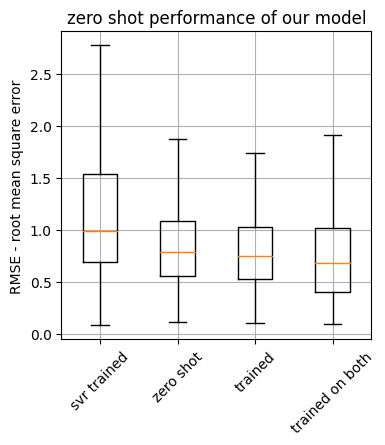

In [38]:
f = FoldStatistic('svr')
f.add(model_statistic_svr)
boxplot_results([f,generalization,gru_noise,gru_noise_trained_with_all],'zero shot performance of our model',['svr trained','zero shot','trained','trained on both'])

In [39]:
pd.DataFrame(dict).dropna().describe()

svr trained   zero shot     trained  trained on both
count   745.000000  745.000000  745.000000       745.000000
mean      1.511318    0.902651    0.853464         0.853413
std       1.897431    0.565153    0.541748         0.938290
min       0.082249    0.118423    0.105894         0.095576
25%       0.694830    0.556773    0.529248         0.401263
50%       0.991036    0.788019    0.744262         0.680142
75%       1.531368    1.086245    1.023718         1.015610
max      18.925484    5.470599    5.545866        17.627365

#### Conclusion

The model generalize well. Even with zer-shot-learning, the model is able to perform as good as the same architecture that is trained from scratch.